In [1]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn

seaborn.set_context('talk')

In [2]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

In [3]:
relevant_columns = ['tools_programming_languages', 'salary_monthly_NETO']
df[relevant_columns]

,tools_programming_languages,salary_monthly_NETO
0,Ninguno,43000.000
1,"HTML, Javascript, Python",63000.000
2,Ninguno,127000.000
3,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.000
4,"CSS, HTML, Javascript, SQL, TypeScript",106000.000
...,...,...
6090,".NET, C#, COBOL, CSS, HTML, Javascript, PHP, S...",97000.000
6091,Ninguno de los anteriores,71000.000
6092,Ninguno de los anteriores,45.753
6093,"C, C++, HTML, Java, Javascript, PHP, Python, SQL",72.000


In [4]:
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  # Remove 'other' option
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [lang.strip().replace(',', '')
          for lang in languages_str.split()]

# Create a new column with the list of languages
df.loc[:, 'cured_programming_languages'] = df.tools_programming_languages\
    .apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages') 

# Duplicate each row of df for each programming language
# mentioned in the response.
# We only include in df_lang the columns we are going to analyze later, so we
# don't duplicate innecesary information.
df_lang = df.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(df[relevant_columns])\
    .rename(columns={0: 'programming_language'})
# Horrible programming style! But a lot of data science code can be written with
# as concatenations of functions (pipelines), and there's no elegant way of
# doing that on Python.
df_lang[:10]

,programming_language,tools_programming_languages,salary_monthly_NETO,cured_programming_languages
0,ninguno,Ninguno,43000.0,[ninguno]
1,html,"HTML, Javascript, Python",63000.0,"[html, javascript, python]"
1,javascript,"HTML, Javascript, Python",63000.0,"[html, javascript, python]"
1,python,"HTML, Javascript, Python",63000.0,"[html, javascript, python]"
2,ninguno,Ninguno,127000.0,[ninguno]
3,bash/shell,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,"[bash/shell, c, css, html, java, javascript, p..."
3,c,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,"[bash/shell, c, css, html, java, javascript, p..."
3,css,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,"[bash/shell, c, css, html, java, javascript, p..."
3,html,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,"[bash/shell, c, css, html, java, javascript, p..."
3,java,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.0,"[bash/shell, c, css, html, java, javascript, p..."


In [5]:
def remove_outlier(df_in, col_name, iqr_factor):
    """
  IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
  accept a dataframe, remove outliers, return cleaned data in a new dataframe
  see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
  """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # interquartile range
    fence_low = q1 - iqr_factor * iqr
    fence_high = q3 + iqr_factor * iqr
    df_inliers = df_in.loc[
        (df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)
    ]
    df_outliers = df_in.loc[
        (df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)
    ]
    return df_inliers, df_outliers

In [7]:
iqr_factor = 2.5
df_main_inliers, df_main_outliers = remove_outlier(df_lang, "salary_monthly_NETO", iqr_factor)
display(len(df_main_inliers) / len(df_lang))

0.9155

In [28]:
df_main_inliers.isna().value_counts()

programming_language  tools_programming_languages  salary_monthly_NETO  cured_programming_languages
False                 False                        False                False                          16479
dtype: int64

In [29]:
df_main_inliers.describe()

,salary_monthly_NETO
count,16479.000000
mean,82701.890461
std,43841.129229
min,1.000000
25%,52500.000000
50%,78400.000000
75%,105000.000000
max,248000.000000


Filtrado de datos. 

In [22]:
language_count = df_lang.programming_language.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'language', 'programming_language': 'frequency'})
language_count[:15]

,language,frequency
0,javascript,2513
1,sql,2154
2,html,1861
3,python,1475
4,java,1453
5,css,1247
6,bash/shell,993
7,php,891
8,.net,823
9,typescript,779


<AxesSubplot:xlabel='language', ylabel='frequency'>

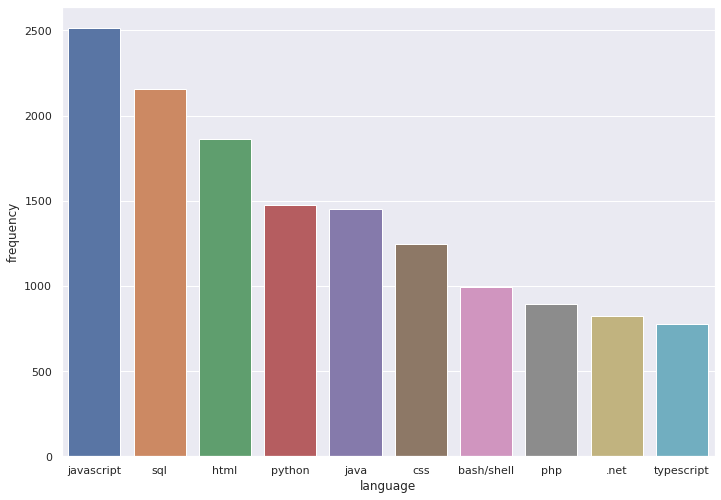

In [23]:
language_count=language_count[language_count['frequency']>735]
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
seaborn.barplot(data=language_count, x='language', y='frequency')
#ver cambiar el ancho
#elijo solo los primeros 5 para una correcta visualizacion

Elegimos los 10 lengujaes mas utilizados por las personas que realizaron la encuensta.